In [1]:
import pickle
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import collections
import random

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
    
def get_vocab_and_vectors(year):
    with open(f"sgns/{year}-vocab.pkl", 'rb') as f:
        vocab = pickle.load(f)
    vectors = np.load(f"sgns/{year}-w.npy")
    return vocab, vectors

vocab, vectors = get_vocab_and_vectors(1950)

def cosine(x, y):
    return np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))

# def find_nearest_neighbors(vector, all_vecs):
#     return np.argsort(np.dot(all_vecs, -vector))


NOT_FOUND = "not_found"
ZERO_VECTOR = "zero_vector"

def vector_lookup(word, vector_map):
    if word not in vector_map:
        return None, NOT_FOUND
    else:
        maybe_vec = vector_map[word]
        if not sum(maybe_vec):
            return None, ZERO_VECTOR
        else:
            return maybe_vec, None
        
def build_map(year):
    vocab, vectors = get_vocab_and_vectors(year)
    return {token:vector for token, vector in zip(vocab, vectors)}

DECADES = [f'19{decade_digit}0' for decade_digit in range(10)]
DIMENSIONS = ['Affluence', 'Cultivation', 'Education', 'Employment', 'Gender', 'Morality', 'Race', 'Status']
COLOR_DICT = {a:b for a,b in zip(DIMENSIONS, sns.color_palette("Set2"))}

vector_maps = {}
for decade in DECADES:
    vector_maps[decade] = build_map(decade)

In [2]:
pair_list = collections.defaultdict(list)

with open('word-pairs.tsv', 'r') as f:
    reader = csv.DictReader(f, delimiter='\t')
    for row in reader:
        pair_list[row['Category']].append((row['Positive'], row['Negative']))

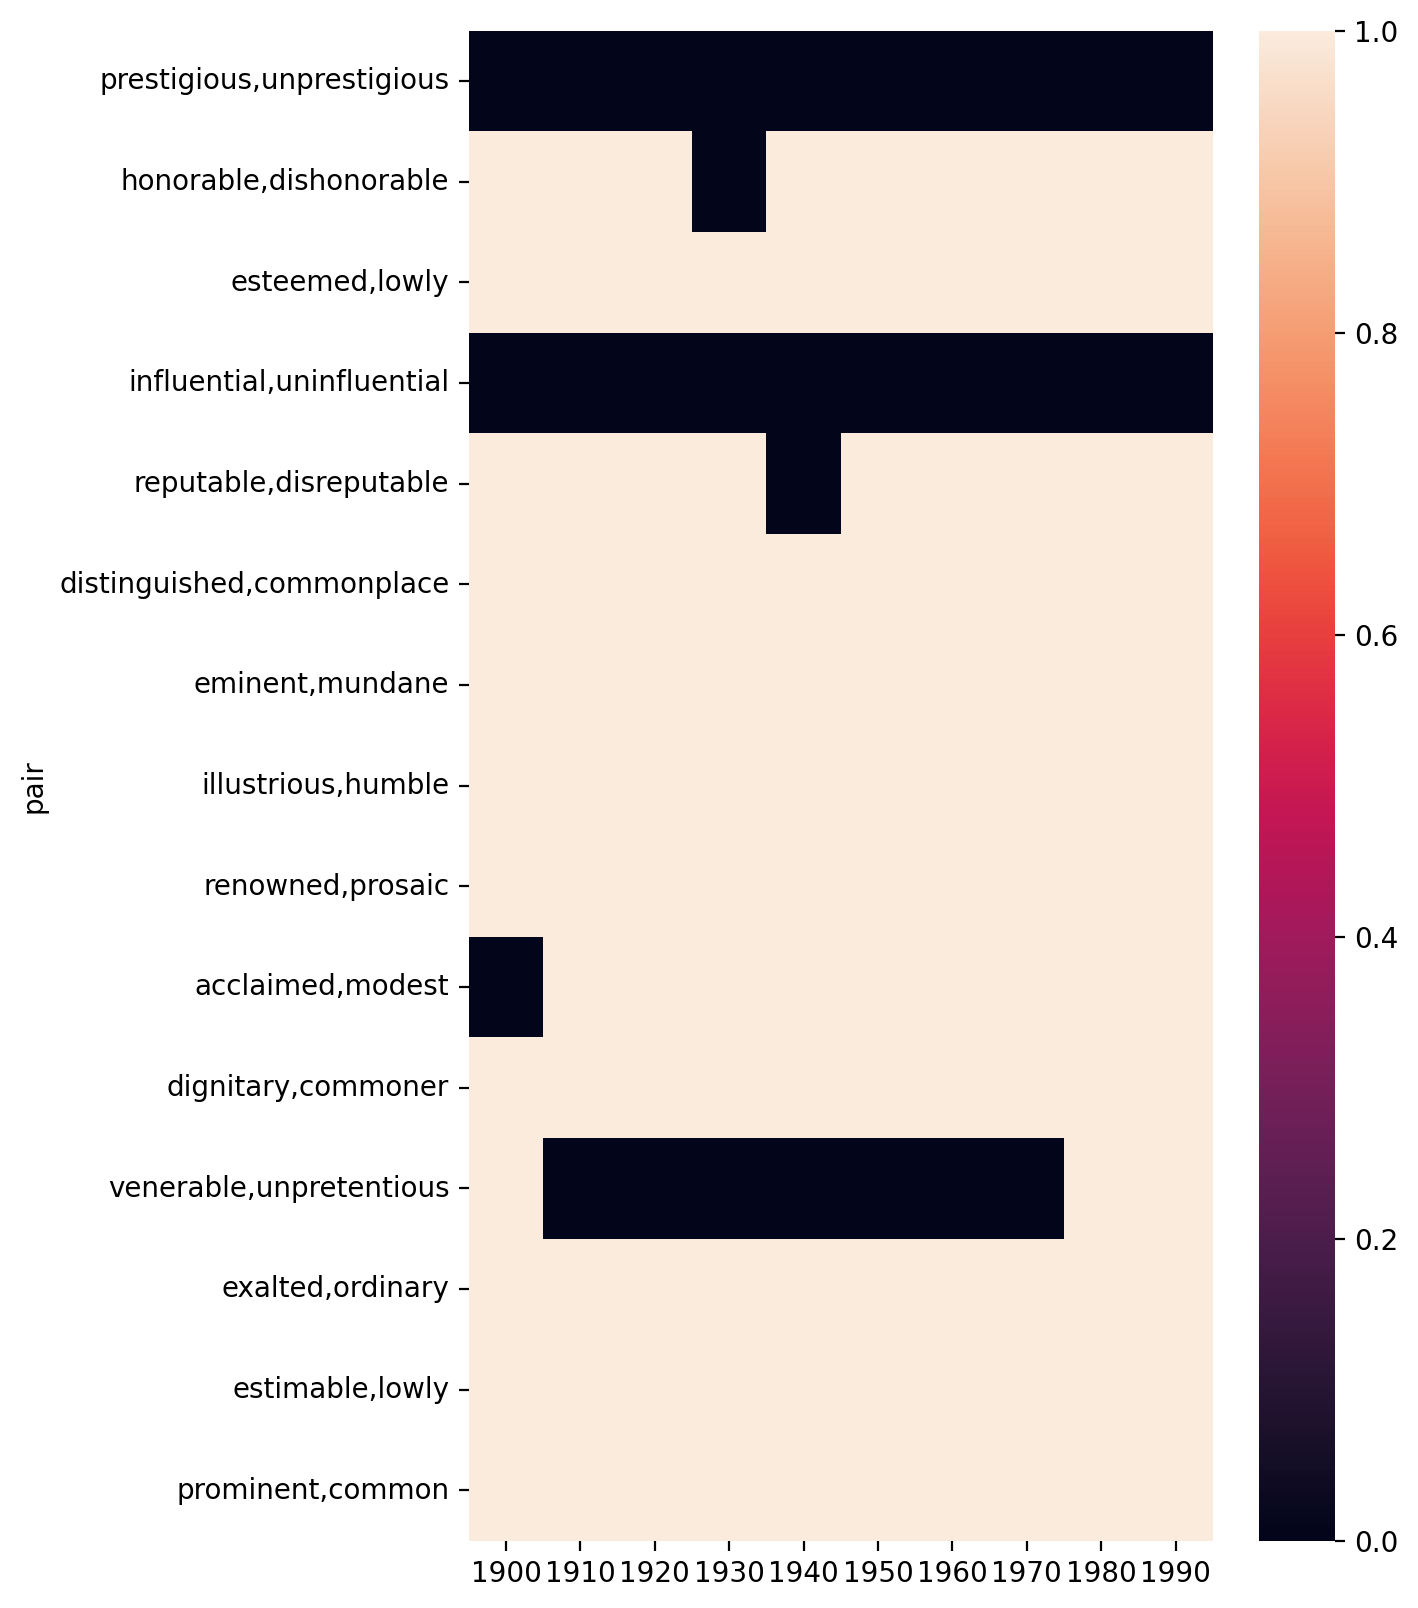

In [3]:
import pandas as pd

plt.figure(figsize=(6, 10), dpi=200)

def get_vector(word, decade):
    return vector_lookup(word, vector_maps[decade])[0]

for category, pairs in pair_list.items():
    if not category == "Status":
        continue
    df_dicts = []
    for pos, neg in pairs:
        row = {"pair": f"{pos},{neg}",}
        for decade, decade_vecs in vector_maps.items():
            maybe_pos = get_vector(pos, decade)
            maybe_neg = get_vector(neg, decade)
            if maybe_pos is not None and maybe_neg is not None:
                result = 1
            else:
                result = 0
            row[decade] = result
        df_dicts.append(row)
    df = pd.DataFrame.from_dict(df_dicts)
    ax = sns.heatmap(df.set_index('pair'), xticklabels=True, yticklabels=True)
    
    

In [4]:
affluence_pairs = pair_list['Affluence']

df_dicts = []
for category, pairs in pair_list.items():
#     if not category == "Employment":
#       continue
    for decade in DECADES:
        #print(decade)
        for held_out_pair in pairs:
            other_pairs = [pair for pair in pairs if not pair == held_out_pair]
            #print(other_pairs)
            pos_vectors = []
            neg_vectors = []
            for pos, neg in other_pairs:
                maybe_pos_vec = get_vector(pos, decade)
                maybe_neg_vec = get_vector(neg, decade)
                if maybe_pos_vec is not None and maybe_neg_vec is not None:
                    pos_vectors.append(maybe_pos_vec)
                    neg_vectors.append(maybe_neg_vec)
            main_vec = sum(pos_vectors) - sum(neg_vectors)
            held_out_pos, held_out_neg = held_out_pair
            maybe_pos_vec = get_vector(held_out_pos, decade)
            maybe_neg_vec = get_vector(held_out_neg, decade)
            if maybe_pos_vec is not None and maybe_neg_vec is not None:
                df_dicts.append({
                    "decade": decade,
                    "category": category,
                    "pair": f"{held_out_pos},{held_out_neg}",
                    "pos_cosine": cosine(maybe_pos_vec, main_vec),
                    "neg_cosine": cosine(maybe_neg_vec, main_vec),
                })

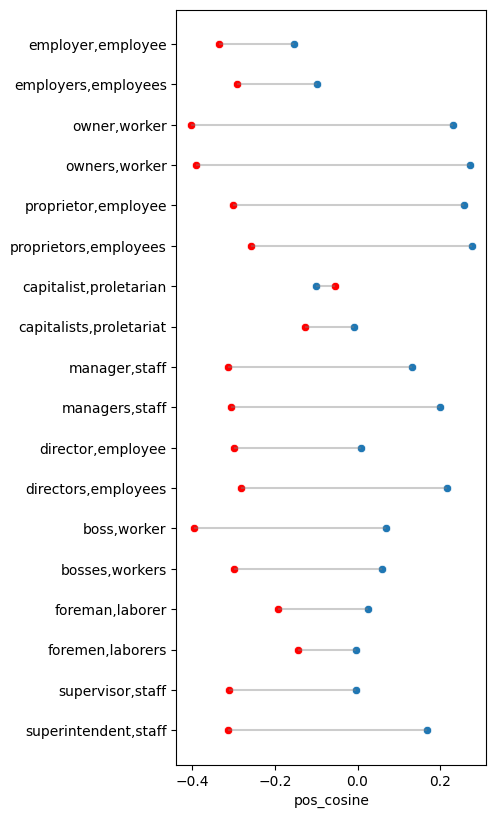

In [5]:
held_out_df = pd.DataFrame(df_dicts)

plt.figure(figsize=(4, 10), dpi=100)
decade_df = held_out_df.loc[(held_out_df['decade'] == "1910") & (held_out_df['category'] == "Employment")]
my_range = list(decade_df['pair'])
sns.scatterplot(y=my_range, x=decade_df["pos_cosine"],)
sns.scatterplot(y=my_range, x=decade_df["neg_cosine"], color='red')
plt.hlines(y=my_range, xmin=decade_df["neg_cosine"], xmax=decade_df["pos_cosine"], color='grey', alpha=0.4)


In [6]:
decade_inversion_counts = collections.defaultdict(lambda:collections.defaultdict(list))

for row in held_out_df.itertuples():
    value = 1 if row.pos_cosine > row.neg_cosine else 0
    decade_inversion_counts[row.category][row.decade].append(value)

<AxesSubplot:xlabel='decade', ylabel='category'>

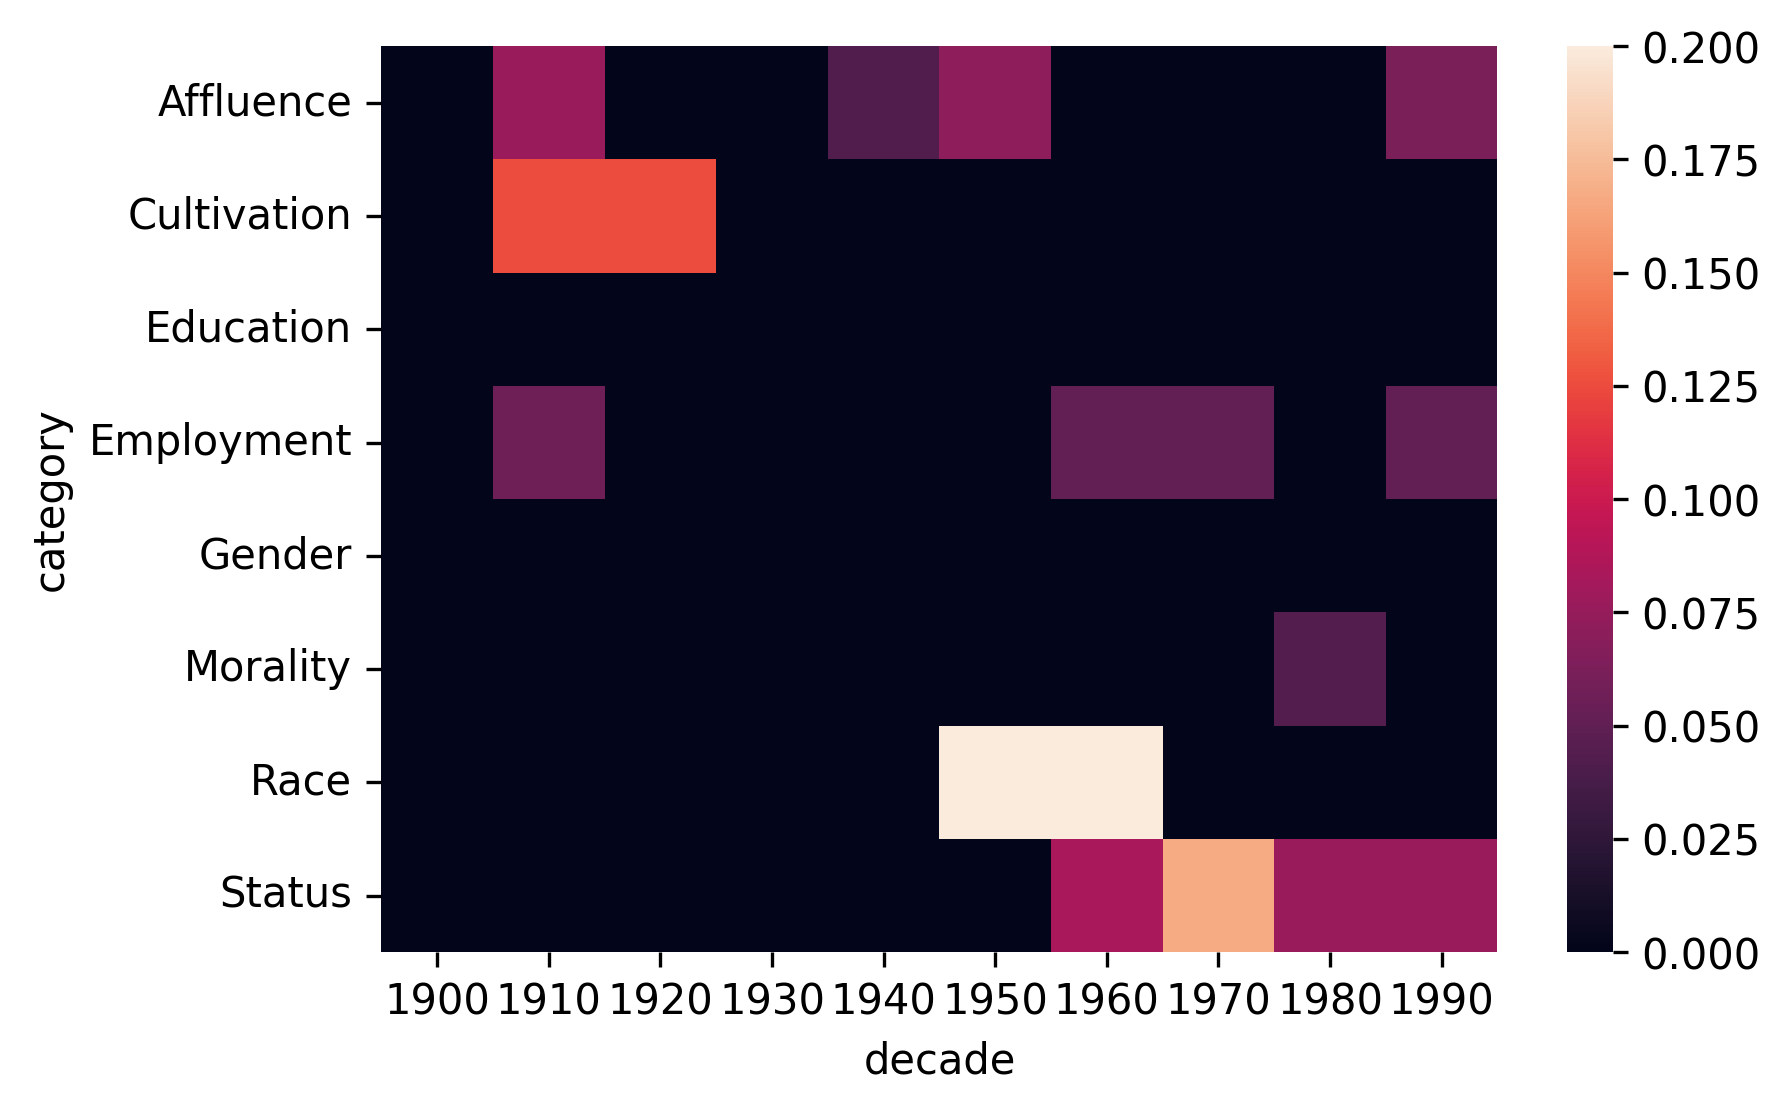

In [7]:
inversion_df_dicts = []
for k, v in decade_inversion_counts.items():
    for a, b in v.items():
        inversion_df_dicts.append({
            "category":k,
        "decade":a,
        "inversions":1.0 - sum(b)/len(b)})
f = pd.DataFrame.from_dict(inversion_df_dicts).pivot("category", "decade", "inversions")
sns.heatmap(f)

In [8]:
def find_nearest_neighbors(vector, all_vecs):
    return np.argsort(np.dot(all_vecs, -vector))

from termcolor import colored

def print_color_row(indices, all_words, pos_words, neg_words):
    result = ""
    c = "█"
    for i in indices:
        word = all_words[i]
        if word in pos_words:
            result += colored(c, 'blue')
        elif word in neg_words:
            result += colored(c, 'red')
        else:
            result += c
    return result

# for category, pairs in pair_list.items():
#     pos_pool, neg_pool = zip(*pairs)
    
#     for decade, decade_vecs in vector_maps.items():
        
#         pos_vecs = [decade_vecs[pos] for pos in pos_pool if pos in decade_vecs] # Not checking for zero vecs because it won't matter
#         neg_vecs = [decade_vecs[neg] for neg in neg_pool if neg in decade_vecs] # Not checking for zero vecs because it won't matter
        
#         diff_vec = sum(pos_vecs)/len(pos_vecs) - sum(neg_vecs)/len(neg_vecs)
#         diff_vec = diff_vec/np.linalg.norm(diff_vec)
        
#         all_words = sorted(decade_vecs.keys())
#         all_vecs = [decade_vecs[word] for word in all_words]
#         all_vecs_array = np.stack(all_vecs, axis=0)
#         indices = find_nearest_neighbors(diff_vec, all_vecs_array)

#         print(print_color_row(indices[:100], all_words, pos_pool, neg_pool) + f"\t{category}, {decade}")
#         print(print_color_row(indices[-100:], all_words, pos_pool, neg_pool))
        
#         for i in indices[:20]:
#             print(all_words[i])
        
#     print()

In [9]:
def get_dimension_vector(decade, pair_list):
    pos_vectors = []
    neg_vectors = []
    for pos, neg in pair_list:
        maybe_pos_vec = get_vector(pos, decade)
        maybe_neg_vec = get_vector(neg, decade)
        if maybe_pos_vec is not None and maybe_neg_vec is not None:
            pos_vectors.append(maybe_pos_vec)
            neg_vectors.append(maybe_neg_vec)
    return sum(pos_vectors) - sum(neg_vectors)
        
final_dimension_vectors = collections.defaultdict(dict)
for decade in DECADES:
    for category, pairs in pair_list.items():
        final_dimension_vectors[decade][category] = get_dimension_vector(decade, pairs)

In [10]:
AFFLUENCE = "Affluence"

def order_by_cosine(cosines):
    sorted_pairs = list(reversed(sorted(cosines.items(), key=lambda x:x[1])))
    return [x[0] for x in sorted_pairs]

def build_cosine_progress_plot(main_dimension):
    df_dicts = []
    for decade, category_dims in final_dimension_vectors.items():
        cosines = {}
        affluence_dimension = category_dims[main_dimension]
        for category, dimension in category_dims.items():
            if category == main_dimension:
                continue
            cosines[category] = cosine(affluence_dimension, dimension)
        order = order_by_cosine(cosines)
        for i, dim in enumerate(order):
            df_dicts.append({
                "rank": i+1,
                "dim": dim,
                "decade": decade,
            })
    return pd.DataFrame.from_dict(df_dicts).pivot("dim", "decade", "rank").reset_index()

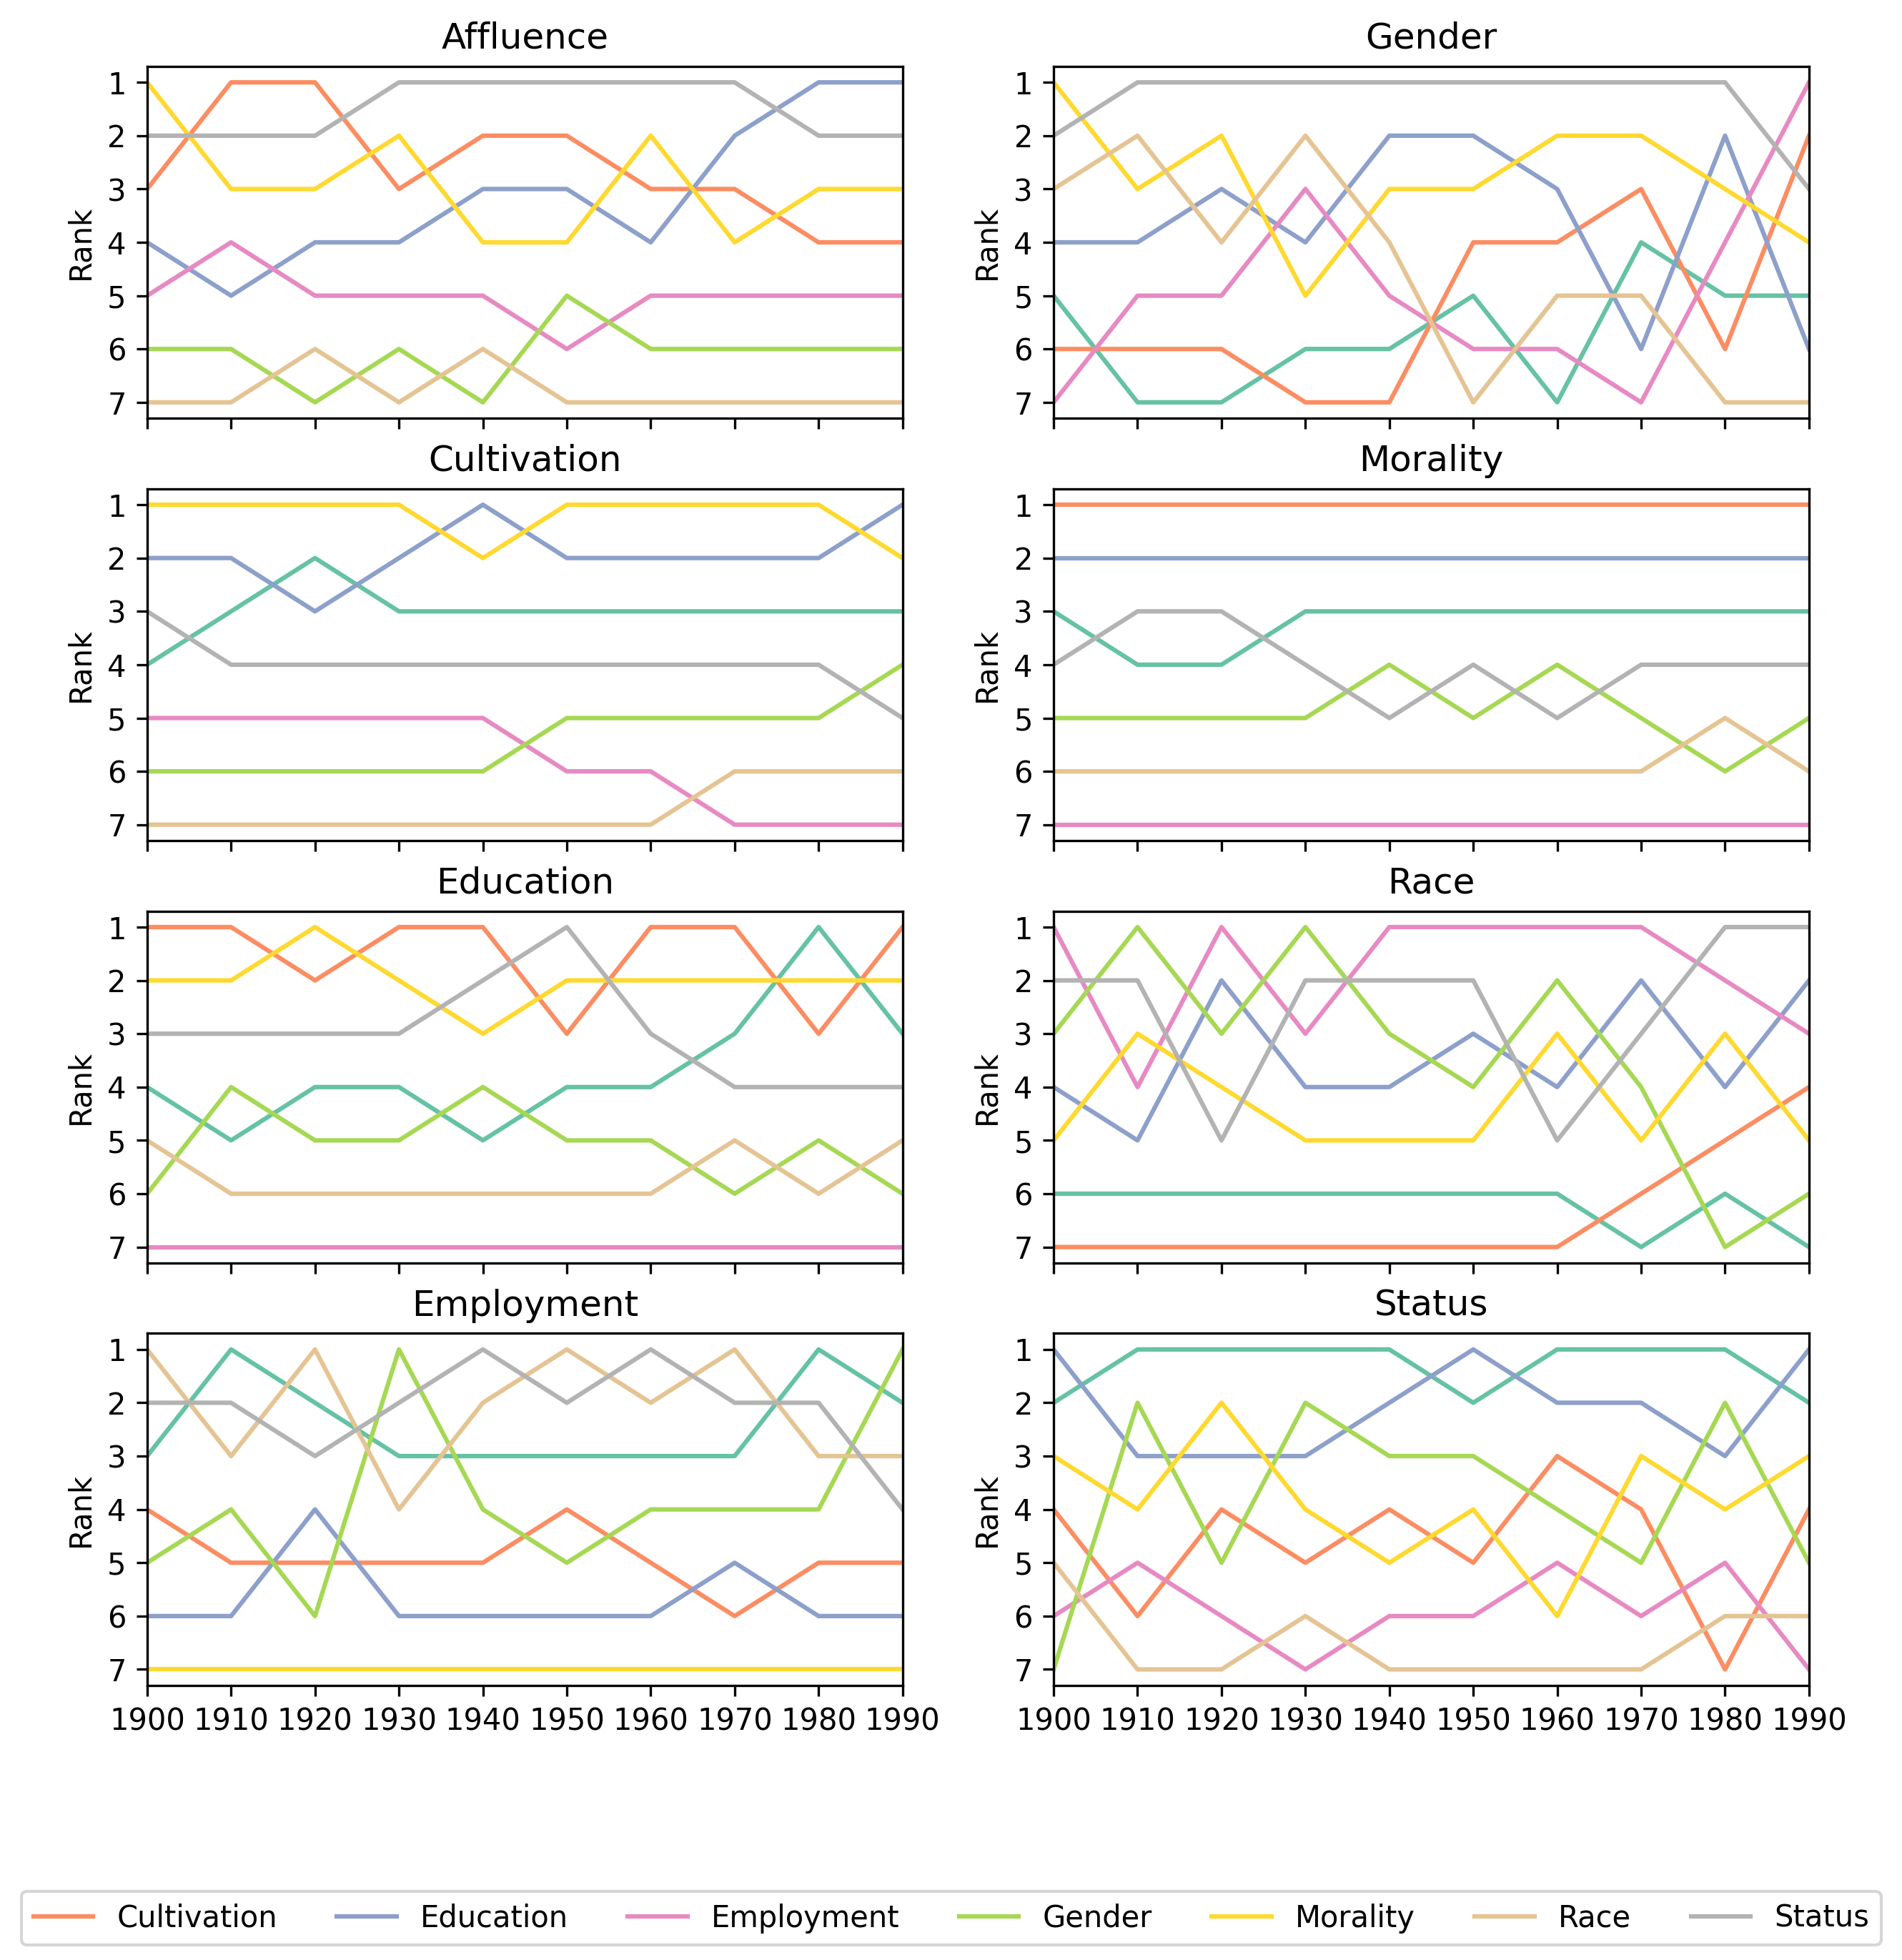

In [11]:
from pandas.plotting import parallel_coordinates

def get_x_y_from_idx(idx):
    return int(idx/4), idx % 4

fig, axs = plt.subplots(4, 2, sharex=True,figsize=(10,10))

for i, dimension in enumerate(DIMENSIONS):
    x, y = get_x_y_from_idx(i)
    ax = axs[y][x]
    dimension_df = build_cosine_progress_plot(dimension)
    parallel_coordinates(dimension_df,"dim",
                         color=[COLOR_DICT[x] for x in dimension_df.dim],
                         axvlines=False, ax=ax)
    ax.invert_yaxis()
    ax.grid(False)
    ax.title.set_text(dimension)
    ax.set_ylabel('Rank')
    ax.get_legend().remove()
    ax.set_yticks(list(reversed(range(1,8))))
    if i ==0:
        fig.legend(loc="lower center", ncol=7)


In [12]:
myvecs = vector_maps["1990"]

In [13]:
diff = get_vector("rich", "1990") - get_vector( "poor", "1990")

In [14]:
all_words = sorted(myvecs.keys())
all_vecs = [myvecs[word] for word in all_words]
all_vecs_array = np.stack(all_vecs, axis=0)
df_dicts = []
for i, (word, vec) in tqdm(list(enumerate(myvecs.items()))):
    if not sum(vec):
        continue
    new_word_vec = vec + diff
    new_word_vec = new_word_vec/np.linalg.norm(new_word_vec)
    nearest_neighbor_index = find_nearest_neighbors(new_word_vec, all_vecs_array)[0]
    if not all_words[nearest_neighbor_index] == word:
        nearest_neighbor_vec = all_vecs_array[nearest_neighbor_index]
        df_dicts.append({
            "word": word,
            "rank": i,
            "nearest_neighbor": all_words[nearest_neighbor_index],
            "closeness":cosine(new_word_vec, nearest_neighbor_vec),
            "rich_cosine": cosine(myvecs['rich'], new_word_vec),
            "poor_cosine": cosine(myvecs['poor'], new_word_vec)
        })
    if i % 1000 == 0:
        print(len(df_dicts))
    

  0%|                                         | 10/100000 [00:00<36:53, 45.17it/s]

0


  1%|▍                                      | 1007/100000 [00:20<33:05, 49.85it/s]

1


  2%|▊                                      | 2010/100000 [00:40<31:51, 51.26it/s]

1


  3%|█▏                                     | 3007/100000 [01:00<33:01, 48.95it/s]

2


  4%|█▌                                     | 4007/100000 [01:20<30:00, 53.32it/s]

2


  5%|█▉                                     | 5008/100000 [01:40<30:09, 52.49it/s]

2


  6%|██▎                                    | 6011/100000 [12:33<30:19, 51.65it/s]

2


  7%|██▋                                    | 7010/100000 [12:53<30:45, 50.39it/s]

4


  8%|███                                    | 8010/100000 [13:12<30:10, 50.80it/s]

5


  9%|███▌                                   | 9007/100000 [13:32<30:03, 50.44it/s]

7


 10%|███▊                                  | 10007/100000 [13:52<30:24, 49.32it/s]

8


 11%|████▏                                 | 11006/100000 [14:12<29:46, 49.81it/s]

9


 12%|████▌                                 | 12008/100000 [14:33<29:24, 49.86it/s]

11


 13%|████▉                                 | 13011/100000 [14:53<29:22, 49.35it/s]

11


 14%|█████▎                                | 14009/100000 [15:14<34:12, 41.90it/s]

11


 15%|█████▋                                | 15006/100000 [15:37<28:08, 50.33it/s]

11


 16%|██████                                | 16006/100000 [15:57<27:33, 50.79it/s]

11


 17%|██████▍                               | 17008/100000 [16:18<28:17, 48.89it/s]

12


 18%|██████▊                               | 18008/100000 [16:38<26:55, 50.74it/s]

12


 19%|███████▏                              | 19008/100000 [16:58<26:45, 50.44it/s]

12


 20%|███████▌                              | 20011/100000 [17:18<26:15, 50.77it/s]

12


 21%|███████▉                              | 21010/100000 [17:38<25:50, 50.95it/s]

12


 22%|████████▎                             | 22011/100000 [17:58<25:38, 50.70it/s]

12


 23%|████████▋                             | 23007/100000 [18:17<25:29, 50.34it/s]

12


 24%|█████████                             | 24009/100000 [18:39<25:24, 49.83it/s]

12


 25%|█████████▌                            | 25006/100000 [18:59<24:42, 50.60it/s]

12


 26%|█████████▉                            | 26010/100000 [19:20<24:26, 50.44it/s]

12


 27%|██████████▎                           | 27011/100000 [19:40<24:12, 50.25it/s]

12


 28%|██████████▋                           | 28008/100000 [20:00<23:45, 50.51it/s]

12


 29%|███████████                           | 29006/100000 [20:19<23:38, 50.03it/s]

13


 30%|███████████▍                          | 30009/100000 [20:40<24:13, 48.17it/s]

13


 31%|███████████▊                          | 31009/100000 [21:01<24:50, 46.29it/s]

13


 32%|████████████▏                         | 32009/100000 [21:22<22:18, 50.81it/s]

13


 33%|████████████▌                         | 33006/100000 [21:41<21:51, 51.09it/s]

13


 34%|████████████▉                         | 34008/100000 [22:01<21:33, 51.01it/s]

13


 35%|█████████████▎                        | 35009/100000 [22:21<23:13, 46.64it/s]

13


 36%|█████████████▋                        | 36006/100000 [22:41<21:02, 50.67it/s]

13


 37%|██████████████                        | 37006/100000 [23:01<20:41, 50.75it/s]

13


 38%|██████████████▍                       | 38006/100000 [23:21<20:22, 50.71it/s]

13


 39%|██████████████▊                       | 39007/100000 [23:43<25:11, 40.34it/s]

13


 40%|███████████████▏                      | 40010/100000 [24:05<20:53, 47.84it/s]

13


 41%|███████████████▌                      | 41011/100000 [24:25<19:52, 49.45it/s]

13


 42%|███████████████▉                      | 42006/100000 [24:46<19:03, 50.72it/s]

13


 43%|████████████████▎                     | 43008/100000 [25:06<18:42, 50.79it/s]

13


 44%|████████████████▋                     | 44006/100000 [25:26<19:33, 47.71it/s]

13


 45%|█████████████████                     | 45007/100000 [25:47<18:23, 49.83it/s]

13


 46%|█████████████████▍                    | 46006/100000 [26:07<19:17, 46.64it/s]

13


 47%|█████████████████▊                    | 47010/100000 [26:28<17:59, 49.07it/s]

13


 48%|██████████████████▏                   | 48007/100000 [26:48<18:11, 47.64it/s]

13


 49%|██████████████████▌                   | 49010/100000 [27:09<17:55, 47.40it/s]

13


 50%|███████████████████                   | 50010/100000 [27:29<16:46, 49.68it/s]

13


 51%|███████████████████▍                  | 51010/100000 [27:50<15:56, 51.22it/s]

13


 52%|███████████████████▊                  | 52009/100000 [28:09<16:16, 49.16it/s]

13


 53%|████████████████████▏                 | 53010/100000 [28:29<16:02, 48.80it/s]

14


 54%|████████████████████▌                 | 54007/100000 [28:49<15:00, 51.09it/s]

14


 55%|████████████████████▉                 | 55007/100000 [29:09<14:54, 50.32it/s]

14


 56%|█████████████████████▎                | 56011/100000 [29:30<14:51, 49.37it/s]

14


 57%|█████████████████████▋                | 57006/100000 [29:50<16:26, 43.60it/s]

14


 58%|██████████████████████                | 58009/100000 [30:14<14:34, 47.99it/s]

14


 59%|██████████████████████▍               | 59010/100000 [30:34<14:13, 48.01it/s]

14


 60%|██████████████████████▊               | 60006/100000 [30:55<13:11, 50.54it/s]

14


 61%|███████████████████████▏              | 61008/100000 [31:15<13:37, 47.71it/s]

14


 62%|███████████████████████▌              | 62007/100000 [31:35<12:39, 50.05it/s]

14


 63%|███████████████████████▉              | 63006/100000 [31:56<12:01, 51.25it/s]

14


 64%|████████████████████████▎             | 64008/100000 [32:15<11:42, 51.20it/s]

14


 65%|████████████████████████▋             | 65010/100000 [32:35<11:24, 51.10it/s]

18


 66%|█████████████████████████             | 66006/100000 [32:54<11:06, 50.98it/s]

127


 67%|█████████████████████████▍            | 67008/100000 [33:14<10:48, 50.90it/s]

221


 68%|█████████████████████████▊            | 68009/100000 [33:34<10:24, 51.19it/s]

293


 69%|██████████████████████████▏           | 69011/100000 [33:53<10:11, 50.69it/s]

341


 70%|██████████████████████████▌           | 70007/100000 [34:13<09:53, 50.51it/s]

370


 71%|██████████████████████████▉           | 71008/100000 [34:33<09:33, 50.53it/s]

436


100%|█████████████████████████████████████| 100000/100000 [34:35<00:00, 48.18it/s]


In [15]:
df_dicts

[{'word': 'poor',
  'rank': 809,
  'nearest_neighbor': 'rich',
  'closeness': 1.0000000000000002,
  'rich_cosine': 1.0000000000000002,
  'poor_cosine': 0.3614056051885565},
 {'word': 'sick',
  'rank': 2636,
  'nearest_neighbor': 'rich',
  'closeness': 0.5400316662437016,
  'rich_cosine': 0.5400316662437016,
  'poor_cosine': -0.20371673760272638},
 {'word': 'unemployed',
  'rank': 6438,
  'nearest_neighbor': 'rich',
  'closeness': 0.532742384103396,
  'rich_cosine': 0.532742384103396,
  'poor_cosine': -0.20181024900650626},
 {'word': 'oppressed',
  'rank': 6911,
  'nearest_neighbor': 'rich',
  'closeness': 0.6073944564866621,
  'rich_cosine': 0.6073944564866621,
  'poor_cosine': -0.1855205948148286},
 {'word': 'poorest',
  'rank': 7874,
  'nearest_neighbor': 'rich',
  'closeness': 0.6063345786892196,
  'rich_cosine': 0.6063345786892196,
  'poor_cosine': -0.17736540766183695},
 {'word': 'homeless',
  'rank': 8452,
  'nearest_neighbor': 'rich',
  'closeness': 0.5268491849720506,
  'rich_c

In [16]:
import json
with open("1990-rich-poor.json", 'w') as f:
    json.dump(df_dicts, f)